
# 🧠 Mini Word Embedding from Scratch (Word2Vec-Style)

This notebook implements a **word embedding model** using the **Skip-gram** approach with **negative sampling**, built entirely from scratch using NumPy.

### 🔍 Features:
- Clean text preprocessing
- Vocabulary building with frequency filtering
- Skip-gram pair generation
- Custom training loop (with negative sampling)
- 2D embedding visualization with PCA

> ✅ Ideal for learning how Word2Vec works internally step-by-step.


### Preprocessing the Text

This cell defines a function `preprocess` that takes raw text as input and prepares it for training the Skip-gram model.


In [8]:
import re
from collections import Counter

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    return tokens

- **`import re`**: Imports the regular expression module, used for pattern matching in strings.
- **`from collections import Counter`**: Imports the `Counter` class, a specialized dictionary subclass for counting hashable objects.
- **`def preprocess(text):`**: Defines the preprocessing function.
    - **`text = text.lower()`**: Converts the input text to lowercase to ensure that words like "The" and "the" are treated as the same word.
    - **`text = re.sub(r'[^a-z\s]', '', text)`**: Uses regular expressions to remove any characters that are not lowercase letters or whitespace. This cleans up the text by removing punctuation and numbers.
    - **`tokens = text.split()`**: Splits the cleaned text into a list of individual words (tokens) based on whitespace.
    - **`return tokens`**: Returns the list of tokens.

### Building the Vocabulary

This cell defines a function `build_vocab` that creates a vocabulary of unique words from the preprocessed tokens.


In [37]:
def build_vocab(tokens, min_count=1):
    word_counts = Counter(tokens)
    vocab = [word for word, count in word_counts.items() if count >= min_count]
    word2idx = {word: i for i, word in enumerate(vocab)}
    idx2word = {i: word for word, i in word2idx.items()}
    return vocab, word2idx, idx2word

# build_vocab(tokens, min_count=1)

- **`def build_vocab(tokens, min_count=1):`**: Defines the vocabulary building function.
    - **`word_counts = Counter(tokens)`**: Uses the `Counter` class to count the occurrences of each word in the input `tokens` list.
    - **`vocab = [word for word, count in word_counts.items() if count >= min_count]`**: Creates a list of words that appear at least `min_count` times. This helps to filter out rare words that might not provide useful information for training.
    - **`word2idx = {word: i for i, word in enumerate(vocab)}`**: Creates a dictionary mapping each word in the vocabulary to a unique integer index.
    - **`idx2word = {i: word for word, i in word2idx.items()}`**: Creates a reverse dictionary mapping each integer index back to its corresponding word.
    - **`return vocab, word2idx, idx2word`**: Returns the vocabulary list, the word-to-index mapping, and the index-to-word mapping.


### Generating Skip-gram Pairs

This cell defines a function `generate_skip_grams` that creates pairs of (target word, context word) from the tokens. These pairs are the training data for the Skip-gram model.


In [38]:
def generate_skip_grams(tokens, word2idx, window_size=2):
    pairs = []
    for i, target in enumerate(tokens):
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(tokens):
                continue
            context = tokens[i + j]
            pairs.append((word2idx[target], word2idx[context]))
    return pairs

# generate_skip_grams(tokens, word2idx, window_size=2)

- **`def generate_skip_grams(tokens, word2idx, window_size=2):`**: Defines the skip-gram pair generation function.
    - **`pairs = []`**: Initializes an empty list to store the skip-gram pairs.
    - **`for i, target in enumerate(tokens):`**: Iterates through each token in the `tokens` list, considering each token as a potential target word.
    - **`for j in range(-window_size, window_size + 1):`**: Iterates through a window of size `window_size` around the target word.
    - **`if j == 0 or i + j < 0 or i + j >= len(tokens):`**: Skips the target word itself (`j == 0`) and ensures that the context word index is within the bounds of the `tokens` list.
    - **`context = tokens[i + j]`**: Gets the context word within the window.
    - **`pairs.append((word2idx[target], word2idx[context]))`**: Appends a tuple of the target word's index and the context word's index to the `pairs` list.
    - **`return pairs`**: Returns the list of skip-gram pairs.

### Initializing Word Embeddings

This cell defines a function `initialize_embeddings` that initializes the weight matrices for the target and context word embeddings.


In [31]:
import numpy as np

def initialize_embeddings(vocab_size, embedding_dim):
    W_target = np.random.rand(vocab_size, embedding_dim)
    W_context = np.random.rand(vocab_size, embedding_dim)
    return W_target, W_context

- **`import numpy as np`**: Imports the NumPy library, which is essential for numerical operations, especially matrix operations.
- **`def initialize_embeddings(vocab_size, embedding_dim):`**: Defines the embedding initialization function.
    - **`W_target = np.random.rand(vocab_size, embedding_dim)`**: Creates a NumPy array (matrix) of size `vocab_size` by `embedding_dim` with random values. This matrix will store the target word embeddings. Each row corresponds to a word in the vocabulary, and each column represents a dimension in the embedding space.
    - **`W_context = np.random.rand(vocab_size, embedding_dim)`**: Creates another NumPy array of the same size for the context word embeddings.
    - **`return W_target, W_context`**: Returns both the target and context embedding matrices.


### Training the Skip-gram Model

This cell defines the core training function `train_skipgram` which implements the Skip-gram algorithm with negative sampling.


In [12]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def train_skipgram(pairs, W_target, W_context, epochs=1000, lr=0.01, neg_samples=5):
    vocab_size = W_target.shape[0]

    for epoch in range(epochs):
        loss = 0
        for target_idx, context_idx in pairs:
            # Positive pair
            v_t = W_target[target_idx]
            v_c = W_context[context_idx]
            score = sigmoid(np.dot(v_t, v_c))
            grad = lr * (1 - score)
            W_target[target_idx] += grad * v_c
            W_context[context_idx] += grad * v_t
            loss += -np.log(score + 1e-9)

            # Negative samples
            for _ in range(neg_samples):
                neg_idx = np.random.randint(0, vocab_size)
                if neg_idx == context_idx:
                    continue
                v_neg = W_context[neg_idx]
                score_neg = sigmoid(np.dot(v_t, v_neg))
                grad_neg = lr * (0 - score_neg)
                W_target[target_idx] += grad_neg * v_neg
                W_context[neg_idx] += grad_neg * v_t
                loss += -np.log(1 - score_neg + 1e-9)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} Loss: {loss:.4f}")
    return W_target



- **`def sigmoid(x):`**: Defines the sigmoid activation function, which squashes values between 0 and 1. This is used to calculate the probability of a context word appearing given a target word.
- **`def train_skipgram(pairs, W_target, W_context, epochs=1000, lr=0.01, neg_samples=5):`**: Defines the training function.
    - **`vocab_size = W_target.shape[0]`**: Gets the size of the vocabulary from the shape of the target embedding matrix.
    - **`for epoch in range(epochs):`**: Iterates through the specified number of training epochs.
    - **`loss = 0`**: Initializes the loss for the current epoch.
    - **`for target_idx, context_idx in pairs:`**: Iterates through each skip-gram pair.
        - **Positive pair**:
            - **`v_t = W_target[target_idx]`**: Gets the embedding vector for the target word.
            - **`v_c = W_context[context_idx]`**: Gets the embedding vector for the context word.
            - **`score = sigmoid(np.dot(v_t, v_c))`**: Calculates the dot product of the target and context vectors and applies the sigmoid function to get the probability of this positive pair.
            - **`grad = lr * (1 - score)`**: Calculates the gradient for the positive pair. The goal is to maximize the probability of the positive pair, so the gradient is proportional to `(1 - score)`.
            - **`W_target[target_idx] += grad * v_c`**: Updates the target word embedding using the calculated gradient and the context vector.
            - **`W_context[context_idx] += grad * v_t`**: Updates the context word embedding using the calculated gradient and the target vector.
            - **`loss += -np.log(score + 1e-9)`**: Adds the negative log-likelihood of the positive pair to the loss. We add a small value (1e-9) to the score to prevent taking the logarithm of zero.
        - **Negative samples**:
            - **`for _ in range(neg_samples):`**: Generates `neg_samples` random negative samples.
            - **`neg_idx = np.random.randint(0, vocab_size)`**: Randomly selects an index for a negative context word.
            - **`if neg_idx == context_idx:`**: Skips if the randomly selected negative index is the same as the positive context index.
            - **`v_neg = W_context[neg_idx]`**: Gets the embedding vector for the negative context word.
            - **`score_neg = sigmoid(np.dot(v_t, v_neg))`**: Calculates the probability of the target word appearing with the negative context word.
            - **`grad_neg = lr * (0 - score_neg)`**: Calculates the gradient for the negative sample. The goal is to minimize the probability of the negative pair, so the gradient is proportional to `(0 - score_neg)`.
            - **`W_target[target_idx] += grad_neg * v_neg`**: Updates the target word embedding.
            - **`W_context[neg_idx] += grad_neg * v_t`**: Updates the negative context word embedding.
            - **`loss += -np.log(1 - score_neg + 1e-9)`**: Adds the negative log-likelihood of the negative sample to the loss.
        - **`if epoch % 100 == 0:`**: Prints the loss every 100 epochs to monitor training progress.
    - **`return W_target`**: Returns the trained target word embedding matrix.

### Getting a Word Embedding

This cell defines a simple function to retrieve the embedding vector for a specific word after training.


In [13]:
def get_word_embedding(word, word2idx, W_target):
    return W_target[word2idx[word]]



- **`def get_word_embedding(word, word2idx, W_target):`**: Defines the function to get a word embedding.
    - **`return W_target[word2idx[word]]`**: Uses the `word2idx` dictionary to get the index of the input word and then retrieves the corresponding row (embedding vector) from the trained target embedding matrix `W_target`.


### Running the Skip-gram Model

This cell puts all the pieces together to run the Skip-gram model on a sample text.


In [24]:
text = "king queen man woman king queen"
tokens = preprocess(text)
# print(tokens)
vocab, word2idx, idx2word = build_vocab(tokens)
# print(vocab, word2idx, idx2word)
pairs = generate_skip_grams(tokens, word2idx, window_size=2)
# print(pairs)
W_target, W_context = initialize_embeddings(len(vocab), embedding_dim=10)
# print(W_target, W_context)
W_trained = train_skipgram(pairs, W_target, W_context)
# print(W_trained)

# Get embedding for a word
embedding = get_word_embedding("king", word2idx, W_trained)
print("Embedding for 'king':", embedding)

Epoch 0 Loss: 143.8219
Epoch 100 Loss: 37.8875
Epoch 200 Loss: 37.3948
Epoch 300 Loss: 38.1787
Epoch 400 Loss: 35.7483
Epoch 500 Loss: 36.3740
Epoch 600 Loss: 37.1366
Epoch 700 Loss: 34.3099
Epoch 800 Loss: 33.9844
Epoch 900 Loss: 36.4906
Embedding for 'king': [-0.84717569  1.22623107  0.03480632  0.48761324 -0.23339249 -1.06556912
 -0.07377733 -0.15588278  0.57155795  1.01317445]


- **`text = "king queen man woman king queen"`**: Defines the input text.
- **`tokens = preprocess(text)`**: Preprocesses the text to get a list of tokens.
- **`vocab, word2idx, idx2word = build_vocab(tokens)`**: Builds the vocabulary and the word-to-index/index-to-word mappings.
- **`pairs = generate_skip_grams(tokens, word2idx, window_size=2)`**: Generates the skip-gram pairs from the tokens.
- **`W_target, W_context = initialize_embeddings(len(vocab), embedding_dim=10)`**: Initializes the target and context embedding matrices with a specified embedding dimension (here, 10).
- **`W_trained = train_skipgram(pairs, W_target, W_context)`**: Trains the Skip-gram model using the generated pairs and initialized embeddings.
- **`embedding = get_word_embedding("king", word2idx, W_trained)`**: Gets the trained embedding vector for the word "king".
- **`print("Embedding for 'king':", embedding)`**: Prints the embedding vector for "king".

This example is very small, so the learned embeddings might not be very meaningful. In practice, Skip-gram is trained on very large text corpora to learn rich and useful word representations.

### Libraries Used

- **`re` (Regular Expression)**: Used for text cleaning and pattern matching in the `preprocess` function.
- **`collections` (specifically `Counter`)**: Used for efficiently counting the frequency of words to build the vocabulary.
- **`numpy`**: The fundamental library for numerical computation in Python. It's used for creating and manipulating the embedding matrices, performing dot products, and implementing the sigmoid function.


In [39]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_embeddings(W, idx2word):
    # Reduce dimensions to 2D
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(W)

    # Plot
    plt.figure(figsize=(8, 6))
    for i, label in idx2word.items():
        x, y = reduced[i]
        plt.scatter(x, y)
        plt.annotate(label, (x, y), fontsize=12)
    plt.title("Word Embeddings (PCA)")
    plt.grid(True)
    plt.show()

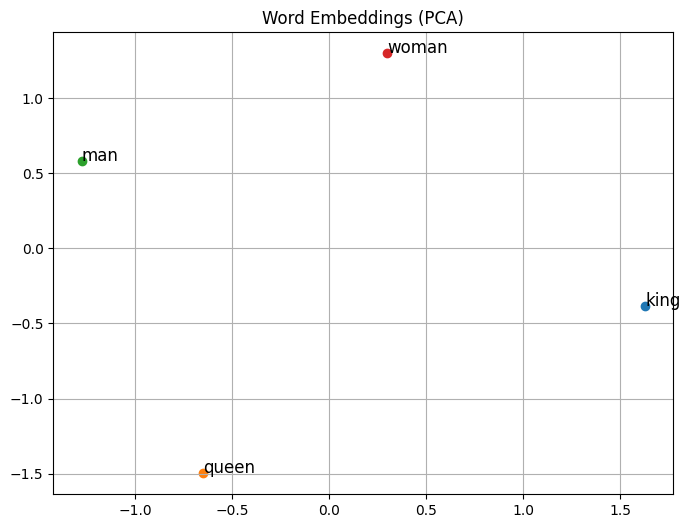

In [40]:
plot_embeddings(W_trained, idx2word)

Epoch 0 Loss: 111.9189
Epoch 100 Loss: 41.8249
Epoch 200 Loss: 44.9434
Epoch 300 Loss: 65.8238
Epoch 400 Loss: 187.2175
Epoch 500 Loss: 474.9543
Epoch 600 Loss: 497.3584
Epoch 700 Loss: 559.5282


/tmp/ipython-input-12-850048426.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Epoch 800 Loss: 580.2514
Epoch 900 Loss: 518.0816


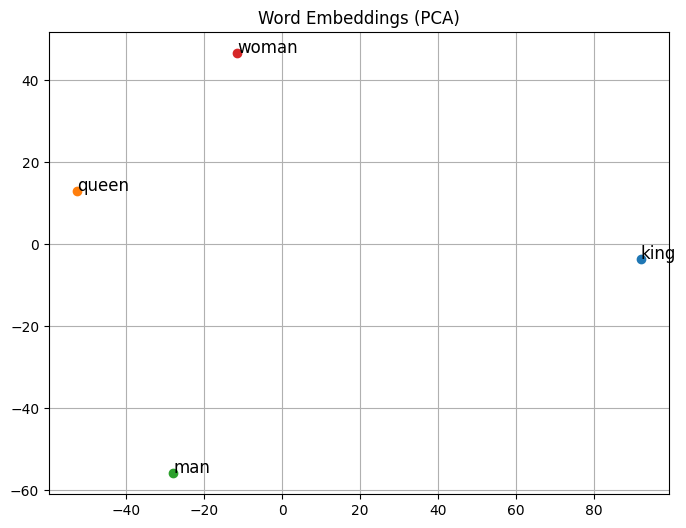

In [42]:
# 🧪 Full End-to-End Example

# Input text
text = "king queen man woman king queen"

# Step 1: Preprocess
tokens = preprocess(text)

# Step 2: Build Vocab
vocab, word2idx, idx2word = build_vocab(tokens)

# Step 3: Generate Skip-gram Pairs
pairs = generate_skip_grams(tokens, word2idx, window_size=2)

# Step 4: Initialize Embeddings
W_target, W_context = initialize_embeddings(len(vocab), embedding_dim=10)

# Step 5: Train Embeddings
W_trained = train_skipgram(pairs, W_target, W_context, epochs=1000, lr=0.05)

# Step 6: Plot
plot_embeddings(W_trained, idx2word)